### Comparison of the coherence metric between the original and surrogate data

In [1]:
# Path to the toolbox
import sys; sys.path.insert(1, '/home/vinicius/storage1/projects/GrayData-Analysis')

import os 
import numpy                   as     np
import pandas                  as     pd
import matplotlib.pyplot       as     plt
from   tqdm                    import tqdm
from   frites.utils            import parallel_func
from   scipy.stats             import ks_2samp, ttest_ind
from   mne.viz                 import circular_layout, \
                                      plot_connectivity_circle

from   GDa.temporal_network    import temporal_network
import GDa.stats.bursting      as     bst

In [2]:
# Create directory to save figures
if not os.path.exists("img/n3.0.4"):
    os.makedirs("img/n3.0.4")

In [3]:
# Kernel size and seed for the surrogate data
_KS   = 1000
_SEED = 12000

#### Load coherence data

In [4]:
#### Original data
net = temporal_network(coh_file=f'super_tensor_k{_KS}.nc', monkey='lucy', 
                       session=1, date='150128', trial_type=[1],
                       behavioral_response=[1], wt=(20,20), drop_trials_after=True,
                       relative=True, verbose=True, q=None, keep_weights=False)

In [5]:
# Extract area names
def _extract_roi(roi, sep):
    # Code by Etiene
    x_s, x_t = [], []
    for r in roi:
        _x_s, _x_t = r.split(sep)
        x_s.append(_x_s), x_t.append(_x_t)
    roi_c = np.c_[x_s, x_t]
    idx = np.argsort(np.char.lower(roi_c.astype(str)), axis=1)
    roi_s, roi_t = np.c_[[r[i] for r, i in zip(roi_c, idx)]].T
    roi_st = [f"{s}{sep}{t}" for s, t in zip(roi_s, roi_t)]
    return roi_s, roi_t, roi_st

In [6]:
roi_s, roi_t, _ = _extract_roi(net.super_tensor.roi.values, '-')

#### Statistical testing the distributions (KS-test and t-test)

In [7]:
# Getting coherence values
coh = net.super_tensor.values

The null hypothesis is that the two distributions are identical, F(x)=G(x) for all x; the alternative is that they are not identical.

**ks-test:** If the KS statistic is small or the p-value is high, then we cannot reject the null hypothesis in favor of the alternative.

**t-test:**  A p-value larger than a chosen threshold (e.g. 5% or 1%) indicates that our observation is not so unlikely to have occurred by chance.

In [8]:
def significance_test(verbose=False, n_jobs=1):
    """
    Method to compute the ks- and t-test for each frequency band 
    in parallel.
    """ 
    net_surr = temporal_network(coh_file=f'super_tensor_s{_SEED}_k{_KS}.nc', monkey='lucy', 
                                session=1, date='150128', trial_type=[1], coh_thr=None,
                                behavioral_response=[1], wt=(20,20), drop_trials_after=True,
                                relative=None, verbose=True, q=None, keep_weights=False)
    coh_surr = net_surr.super_tensor.values
    
    def _for_band(band):
        # Store p-value for KS-test
        ks = np.zeros(coh.shape[0])
        # Store p-value for t-test
        tt = np.zeros(coh.shape[0])
        for i in range( coh.shape[0] ):
            ks[i] = ks_2samp(coh[i,band,...].flatten(),coh_surr[i,band,...].flatten(),  alternative='two-sided')[1]
            tt[i] = ttest_ind(coh[i,band,...].flatten(),coh_surr[i,band,...].flatten(), alternative='two-sided')[1]
        return np.array([ks,tt])
    # define the function to compute in parallel
    parallel, p_fun = parallel_func( _for_band, n_jobs=n_jobs, 
                                     verbose=verbose, total=coh.shape[1]
                                   )
    p_values = parallel(p_fun(band) for band in range(coh.shape[1]))
    return np.asarray(p_values).T

In [9]:
p_values = significance_test(verbose=True,n_jobs=5)

  0%|          |  : 0/5 [00:00<?,       ?it/s]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  1.1min remaining:  1.6min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  1.7min finished


In [10]:
# p-values
p = 1/100

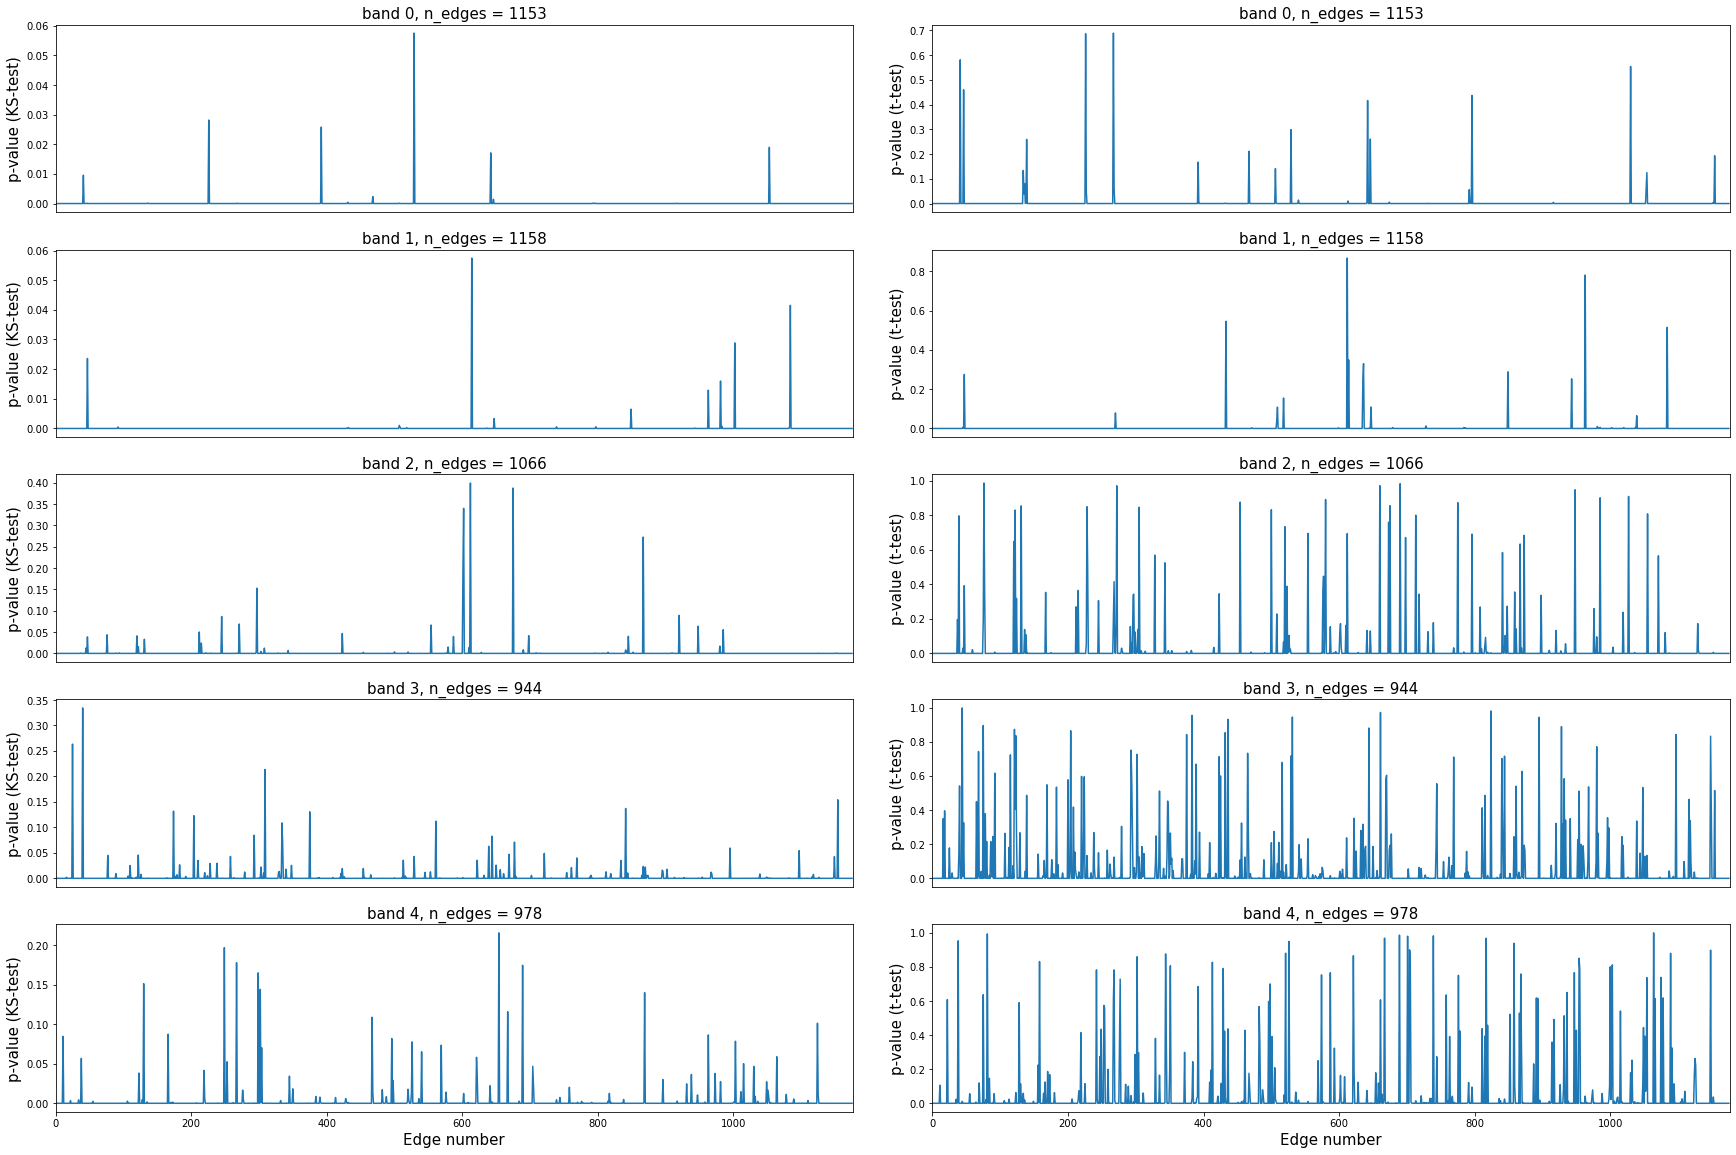

In [11]:
plt.figure(figsize=(30,20))
count = 1
for i in range(net.super_tensor.sizes['freqs']):
    plt.subplot(5,2,count)
    # Plot KS-test p-value
    plt.plot(p_values[:,0,i])
    plt.ylabel('p-value (KS-test)', fontsize=15)
    plt.title(f'band {i}, n_edges = {np.sum(p_values[:,1,i]<p)}', fontsize=15)
    plt.xlim([0,p_values.shape[0]])
    if i == 4: plt.xlabel('Edge number', fontsize=15)
    else: plt.xticks([])
    count += 1
    plt.subplot(5,2,count)
    # Plot t-test p-value
    plt.plot(p_values[:,1,i])
    plt.ylabel('p-value (t-test)', fontsize=15)
    count += 1
    if i == 4: plt.xlabel('Edge number', fontsize=15)
    else: plt.xticks([])
    plt.title(f'band {i}, n_edges = {np.sum(p_values[:,1,i]<p)}', fontsize=15)
    plt.xlim([0,p_values.shape[0]])
plt.subplots_adjust(wspace=0.1)
plt.savefig('img/ks_test.png', dpi=200)

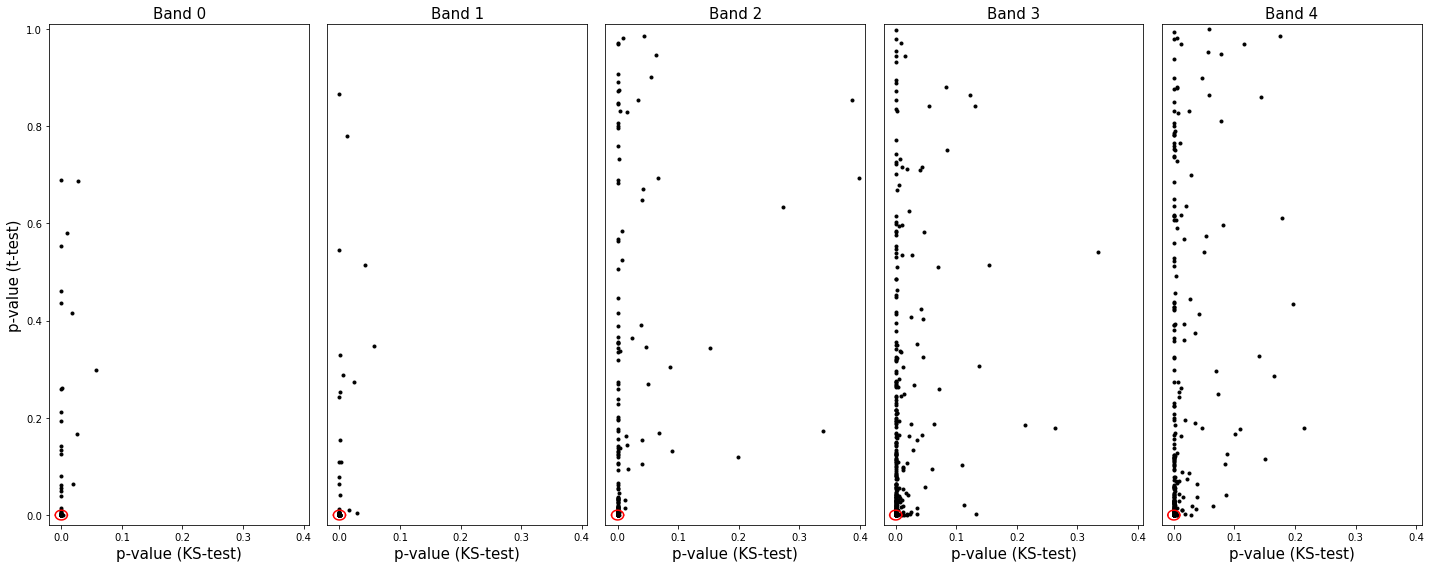

In [12]:
plt.figure(figsize=(20,8))
for i in range(net.super_tensor.sizes['freqs']):
    plt.subplot(1,5,i+1)
    # Create scatter plot 
    plt.scatter(p_values[:,0,i],p_values[:,1,i], marker='.', color='k')
    # Surround the area corresponding to the links with low p-value 
    x = np.linspace(-p,p,100)
    y = np.sqrt(p**2-x**2)
    plt.plot(x,y,'r')
    plt.plot(x,-y,'r')
    if i==0: plt.ylabel('p-value (t-test)', fontsize=15)
    if i>0: plt.yticks([])
    plt.xlabel('p-value (KS-test)', fontsize=15)
    plt.title(f'Band {i}', fontsize=15)
    plt.ylim(-0.02, p_values[:,1,:].max()+0.01)
    plt.xlim(-0.02, p_values[:,0,:].max()+0.01)
plt.tight_layout()

#### Checking a few histograms with p<1/100

In [13]:
net_surr = temporal_network(coh_file=f'super_tensor_s{_SEED}_k{_KS}.nc', monkey='lucy', 
                            session=1, date='150128', trial_type=[1], coh_thr=None,
                            behavioral_response=[1], wt=(20,20), drop_trials_after=True,
                            relative=None, verbose=True, q=None, keep_weights=False)

coh_surr = net_surr.super_tensor.values

In [14]:
# Siginificant links in all bands (KS-test)
ks_idx = (p_values[:,0,0]<p)*(p_values[:,0,1]<p)*(p_values[:,0,2]<p)*(p_values[:,0,3]<p)*(p_values[:,0,4]<p)
# Siginificant links in all bands (t-test)
tt_idx = (p_values[:,1,0]<p)*(p_values[:,1,1]<p)*(p_values[:,1,2]<p)*(p_values[:,1,3]<p)*(p_values[:,1,4]<p)
# Siginificant links in all bands (KS-test + t-test)
idx    = ks_idx*tt_idx

In [15]:
# Sample four edge indexes
ei  = np.sort( np.random.choice( np.where(idx==True)[0], 4) )

100%|██████████| 5/5 [00:00<00:00,  8.70it/s]


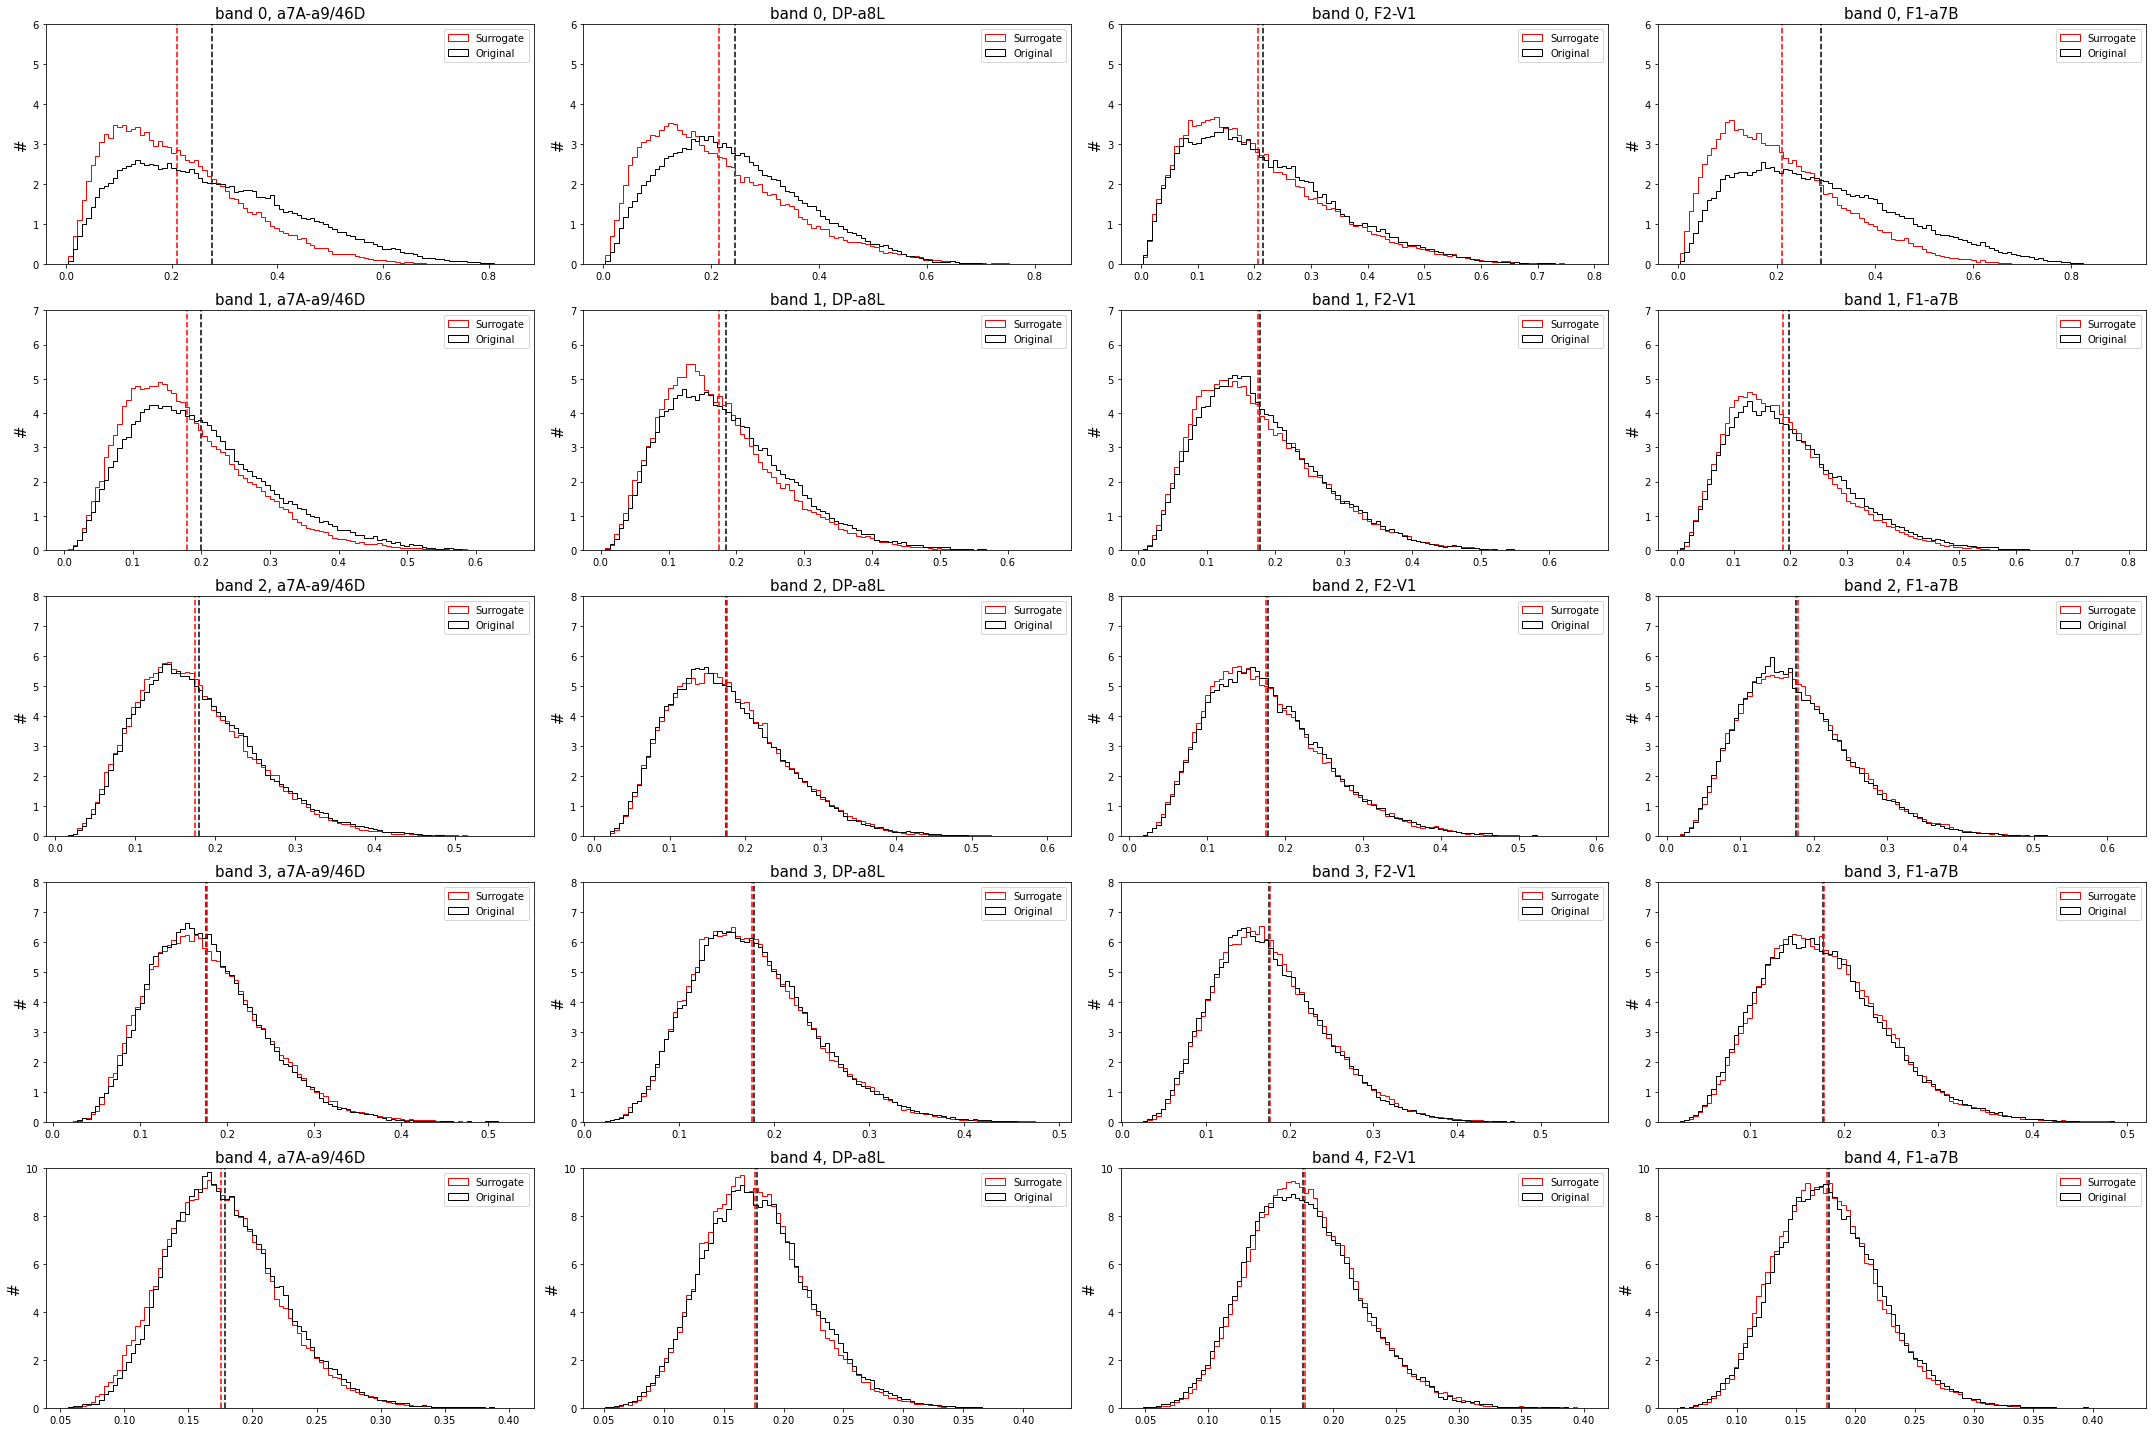

In [16]:
# Saving distributions for trial shuffling surrogates
count = 1
y_max = np.array([3,4,5,5,7])+3
plt.figure(figsize=(30,20))
for i in tqdm( range(net.super_tensor.sizes['freqs']) ):
    for r in ei:#tqdm( range(coh.sizes['roi']) ):
        bins = np.linspace(coh[r,i,...].min(),coh[r,i,...].max(),100)
        plt.subplot(net.super_tensor.sizes['freqs'],len(ei),count)
        plt.hist(coh_surr[r,i,...].flatten(), bins=bins, density=True, histtype='step', fill=False, color='r', label=f'Surrogate');
        plt.hist( coh[r,i,...].flatten(), bins=bins,  density=True, histtype='step', fill=False, color='k', label='Original', lw=1);
        # Compute mean to plot
        m_orig = coh[r,i,...].mean()
        m_surr = coh_surr[r,i,...].mean()
        # Plot mean values as vertical bar
        plt.ylim(0,y_max[i])
        plt.vlines(m_orig, 0, 10, colors='k', linestyles='dashed')
        plt.vlines(m_surr, 0, 10, colors='r', linestyles='dashed')
        plt.title(f'band {i}, {net.super_tensor.roi.values[r]}', fontsize=15)
        plt.ylabel('#', fontsize=15) 
        plt.legend()
        count += 1
plt.tight_layout()

### Plotting number of siginificant links for each pair of regions

In [17]:
unique_rois = np.unique( np.concatenate( (roi_s, roi_t) ) )
mapping     = dict( zip(unique_rois,range(len(unique_rois))) )

#fig = plt.figure(figsize=(12,12))
colors = ['g','r','r','r','#00fbff', 
          'g', 'white', 'g','g','g',
          'b','m','b','b','b','#00fbff', 
          '#00fbff', '#00fbff', 'b', 'b', 'b', 'b']
# Order the nodes according to region
node_order = np.argsort(colors)
colors     = np.sort(colors)
_colorbar  = True

for band in range(5):
    idx = p_values[...,band]<p
    idx = idx[:,0]*idx[:,1]

    s,t,_ = _extract_roi(net.super_tensor.roi[idx].values, "-")

    df    = pd.DataFrame( net.super_tensor.roi[idx].values , columns=["links"])

    links  = df["links"].value_counts(normalize=False).index.values
    counts = df["links"].value_counts(normalize=False).values
    s,t,_  = _extract_roi(links, "-")

    df     = pd.DataFrame(np.array([links, s, t, counts]).T, columns=["links", "sources", "targets", "counts"])

    df.replace({'sources': mapping, 'targets': mapping}, inplace=True)

    m      = np.zeros((len(unique_rois),len(unique_rois)))

    c=0
    for i,j in zip(df.sources.values,df.targets.values):
        m[i,j]=m[j,i]= df.counts.values[c]
        c = c + 1
    
    m = m[np.ix_(node_order)]
    
    fig = plt.figure(figsize=(10,10))
    plot_connectivity_circle(m,unique_rois[node_order], colormap="hot_r", facecolor="white", vmin=0, vmax=20,node_colors=colors,
                         textcolor="k", fig=fig, colorbar=_colorbar, colorbar_size=0.4, colorbar_pos=(-1, 0.5), linewidth=3,
                         title=f"Band {band}", fontsize_title=20,fontsize_names=12, subplot=111, show=False);
    plt.savefig(f"img/n3.0.4/sig_links_b{band}_ks{_KS}.pdf", transparent=True)
    plt.close()